# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import sys
# import javabridge
# import bioformats

script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = os.path.abspath(os.path.join(script_dir, "..", "..", "data_processed"))
dir_path = os.path.abspath(
    os.path.join(
        script_dir,
        "..",
        "..",
        "data_raw_big/Xenium_V1_FF_Mouse_Brain_MultiSection_1_outs",
    )
)
file_path = os.path.join(data_dir, "morphology_focus.tif")

### Setup

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import re

In [33]:
DATA_DIRECTORY = data_dir
CELL_IMAGES = os.path.join(DATA_DIRECTORY, "cell_images_py")
SIZE = (50, 50)

## Loading in and displaying images

In [34]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    files.sort()
    return [
        Image.open(file).convert("L")
        if None in size
        else Image.open(file).convert("L").resize(size)
        for file in files
    ]

In [35]:
# cluster_A_files = os.path.join(CELL_IMAGES, os.listdir(os.path.join(CELL_IMAGES, 'cluster_8')))
cluster_A_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_8"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_8"))
]
cluster_B_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_13"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_13"))
]

In [36]:
cluster_A_images = get_cluster_images(8)
cluster_B_images = get_cluster_images(13)
cluster_A_images_resized = get_cluster_images(8, size=SIZE)
cluster_B_images_resized = get_cluster_images(13, size=SIZE)

In [37]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = (
        nrows * 1
    )  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis("off")

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()


# display_images_in_grid(cluster_A_images_resized, ncols=10, cmap="gray")

## Cell boundary and masking

### Setup

In [38]:
from shapely.geometry import Polygon

# import rasterio
# from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

In [39]:
cell_boundaries_raw = pd.read_csv("../../data_processed/cell_boundaries.csv.gz")


def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r"cell_(\d+)\.png"
    return [int(re.search(pattern, file).group(1)) for file in files]


cluster_A_cell_ids = get_cluster_cell_ids(8)
cluster_B_cell_ids = get_cluster_cell_ids(13)

### Masking one cell

In [40]:
cell_boundaries = cell_boundaries_raw.loc[
    cell_boundaries_raw["cell_id"].isin(cluster_A_cell_ids + cluster_B_cell_ids)
]

In [41]:
def get_masked_image(
    image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame
):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries["cell_id"] == cell_id].copy()
    cell_boundary["vertex_x_scaled"] = 1 + (
        (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min()) * scaling_factor
    )
    cell_boundary["vertex_y_scaled"] = 1 + (
        (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min()) * scaling_factor
    )
    polygon = np.array(
        list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
    )
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)
    return masked_image

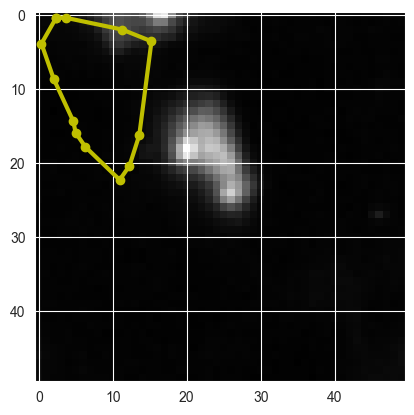

In [42]:
index = 0

cell_boundary = cell_boundaries[
    cell_boundaries["cell_id"] == cluster_A_cell_ids[index]
].copy()
img_A = cluster_A_images[index].convert("L")
img_A_resized = cluster_A_images_resized[index].convert("L")

# Calculate scaling factor
scaling_factor = 1 / 0.22
height, width = np.array(img_A).shape

# Calculate scaled x and y coordinates
cell_boundary["vertex_x_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
            * scaling_factor
        )
    )
    * 50
    / width
)
cell_boundary["vertex_y_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
            * scaling_factor
        )
    )
    * 50
    / height
)

# Visualize the image
plt.clf()
plt.close()
plt.imshow(img_A_resized, cmap="gray")
plt.plot(
    cell_boundary["vertex_x_scaled"],
    cell_boundary["vertex_y_scaled"],
    "y-o",
    linewidth=3,
)
plt.show()

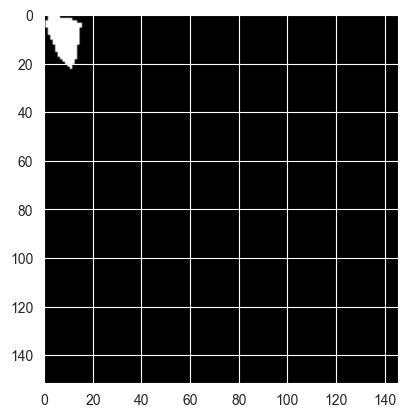

In [43]:
height, width = np.array(img_A.convert("L")).shape
polygon = np.array(
    list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
)
mask = polygon2mask((height, width), polygon)
masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)

# Display the masked image
# result = np.where(masked_image.mask, 0, masked_image)  # image with mask
result = np.where(masked_image.mask, 0, 1)  # just the mask
plt.imshow(result, cmap="gray")
plt.show()

### Masking all cells

In [44]:
def get_cluster_masked_images(cluster: int, size=(None, None), masked=False):
    images = get_cluster_images(cluster)
    if None not in size:  # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)

    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[
        cell_boundaries_raw["cell_id"].isin(cell_ids)
    ].copy()

    # Calculate scaling factor
    scaling_factor = 1 / 0.22

    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        if masked:
            # get shape of original image (without resize)
            height, width = np.array(image).shape
            # scaling factor for cell boundary, only if size is given
            resize_x = 50 / width if None not in size else 1
            resize_y = 50 / height if None not in size else 1

            # get cell boundary coordinates for the image
            cell_boundary = cell_boundaries.loc[
                cell_boundaries["cell_id"] == cell_id
            ].copy()
            # Calculate scaled x and y coordinates
            cell_boundary["vertex_x_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
                    * scaling_factor
                )
            ) * resize_x
            cell_boundary["vertex_y_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
                    * scaling_factor
                )
            ) * resize_y

            # create the mask
            polygon = np.array(
                list(
                    zip(
                        cell_boundary["vertex_y_scaled"],
                        cell_boundary["vertex_x_scaled"],
                    )
                )
            )
            mask = polygon2mask((height, width) if None in size else SIZE, polygon)
            # mask the image
            masked_image = np.ma.masked_array(
                np.copy(image if None in size else image_resized),
                np.invert(mask),
                fill_value=0,
            )
            result[cell_id] = np.where(masked_image.mask, 0, masked_image)
        else:
            result[cell_id] = np.copy(image if None in size else image_resized)

    return result

In [45]:
masked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=True)
    for cluster in range(1, 29)
}

unmasked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=False)
    for cluster in range(1, 29)
}

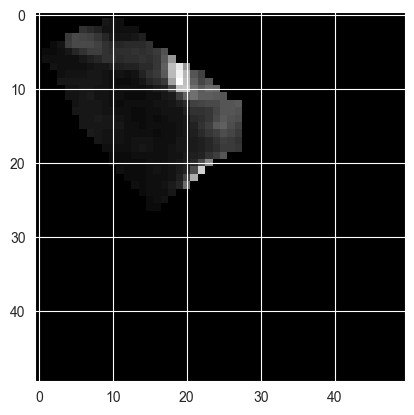

In [46]:
# display_images_in_grid(masked_cells[1])
cluster = 1
index = 3
plt.clf()
plt.close()
plt.imshow(
    masked_cells[cluster][list(unmasked_cells[cluster].keys())[index]], cmap="gray"
)
plt.show()

## Deep Learning

In [47]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

### Make the dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, images_dict, transform=None):
        self.images_dict = images_dict
        self.labels = []
        self.images = []
        for cluster, images in images_dict.items():
            self.images.extend(images.values())
            self.labels.extend([cluster - 1] * len(images))
        self.transform = transform  # Transformation to apply to each image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and normalize if necessary
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        image_tensor = torch.unsqueeze(image_tensor, 0)
        if self.transform:
            image_tensor = self.transform(image_tensor)  # Apply transformation
        # Convert label to PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor

In [101]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model_clusters(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    predictions, true_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_labels = outputs.argmax(1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Metrics calculation
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    ari = adjusted_rand_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None, zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=0)

    # Confusion Matrix
    conf_mat = confusion_matrix(true_labels, predictions)
    
    return {
        "Accuracy": accuracy,
        "Precision": precision_weighted,
        "Recall": recall_weighted,
        "F1 Score": f1_weighted,
        "Adjusted Rand Index": ari,
        "Precision by cluster":precision,
        "Recall by cluster":recall,
        "F1 score by cluster":f1,
        "confusion_matrix": conf_mat,
    }




In [102]:
import torch


def calculate_mean_std(images):
    # Initialize variables to accumulate the sum and sum of squares
    n_images = len(images)
    mean = torch.zeros(1)
    squared_sum = torch.zeros(1)

    for image in images:
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        mean += torch.mean(image_tensor)
        squared_sum += torch.mean(image_tensor**2)

    # Calculate mean and standard deviation
    mean /= n_images
    std = torch.sqrt(squared_sum / n_images - mean**2)

    return mean.item(), std.item()


mean, std = calculate_mean_std(unmasked_cells)

#### Load data and create dataloaders

In [103]:
from torchvision.transforms import AutoAugmentPolicy
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.RandomRotation(50),
        transforms.RandomResizedCrop(50, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(
            [
                mean,
            ],
            [
                std,
            ],
        ),  # Normalize the image
    ]
)
custom_dataset = CustomDataset(unmasked_cells, train_transforms)





### Make the models

#### Random simple model

In [52]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(
            64 * 6 * 6, 128
        )  # Adjust input size based on your image size
        self.fc2 = nn.Linear(128, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 64 * 6 * 6)  # Adjust input size based on your image size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Lab 4b Model

In [53]:
class LabModel(nn.Module):
    def __init__(self):
        super(LabModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(
            64 * 12 * 12, 128
        )  # Adjust input size based on your image size
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 28)  # Assuming 2 classes for binary classification

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 12 * 12)  # Adjust input size based on your image size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

#### AlexNet

In [54]:
class AlexNet(nn.Module):
    def __init__(self, num=28):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32 * 12 * 12, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 32 * 12 * 12)
        return self.classifier(x)
        # return x

In [55]:
# Define the ResNet model
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


class ModifiedResNet50(models.ResNet):
    def __init__(self, weights=None, num_classes=28, *args, **kwargs):
        super(ModifiedResNet50, self).__init__(
            block=models.resnet.Bottleneck, layers=[3, 4, 6, 3], *args, **kwargs
        )

        # Initialize a new fully connected layer with the correct number of classes
        self.fc = nn.Linear(2048, num_classes)

        # If weights is provided, load the state_dict with strict=False to avoid errors
        if weights is not None:
            state_dict = weights.state_dict()

            # Remove the weights related to the fully connected layer to avoid mismatch
            if "fc.weight" in state_dict and "fc.bias" in state_dict:
                del state_dict["fc.weight"]
                del state_dict["fc.bias"]

            self.load_state_dict(state_dict, strict=False)

        # Modify the first convolutional layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the first layer's weights, if weights were provided
        if weights is not None:
            with torch.no_grad():
                original_first_layer = state_dict["conv1.weight"]
                self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [56]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


class ModifiedResNet18(models.ResNet):
    def __init__(self, weights=None, num_classes=28, *args, **kwargs):
        super(ModifiedResNet18, self).__init__(
            block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], *args, **kwargs
        )

        # Initialize a new fully connected layer with the correct number of classes
        self.fc = nn.Linear(512, num_classes)

        # If weights is provided, load the state_dict with strict=False to avoid errors
        if weights is not None:
            state_dict = weights.state_dict()

            # Remove the weights related to the fully connected layer to avoid mismatch
            if "fc.weight" in state_dict and "fc.bias" in state_dict:
                del state_dict["fc.weight"]
                del state_dict["fc.bias"]

            self.load_state_dict(state_dict, strict=False)

        # Modify the first convolutional layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the first layer's weights, if weights were provided
        if weights is not None:
            with torch.no_grad():
                original_first_layer = state_dict["conv1.weight"]
                self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [57]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define a modified Vision Transformer (ViT) with a dropout layer
class ModifiedViT(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224",
        pretrained=True,
        num_classes=1000,
        dropout_rate=0.3,  # Default dropout rate
    ):
        super(ModifiedViT, self).__init__()

        # Load the pretrained ViT model
        self.vit = timm.create_model(
            model_name, pretrained=pretrained, num_classes=num_classes
        )

        # Modify the patch embedding to handle grayscale images
        original_patch_embedding = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1,
            original_patch_embedding.out_channels,
            kernel_size=original_patch_embedding.kernel_size,
            stride=original_patch_embedding.stride,
            padding=original_patch_embedding.padding,
            bias=False,
        )

        # If using pretrained weights, adjust for grayscale
        if pretrained:
            with torch.no_grad():
                original_weight = original_patch_embedding.weight.mean(
                    dim=1, keepdim=True
                )
                self.vit.patch_embed.proj.weight.data = original_weight

        # Add dropout layer after patch embedding
        self.dropout = nn.Dropout(p=dropout_rate)

        # Replace the classifier head
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit.patch_embed(x)

        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Apply positional dropout and add positional embedding
        x = self.vit.pos_drop(x + self.vit.pos_embed)

        # Apply dropout before entering transformer blocks
        x = self.dropout(x)

        # Forward through the transformer blocks
        x = self.vit.blocks(x)

        # Apply normalization
        x = self.vit.norm(x)

        # Select CLS token and apply final dropout
        x = self.dropout(x[:, 0])

        # Final classifier head
        x = self.vit.head(x)

        return x

### Train

In [156]:
import os
import torch
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import RepeatedKFold

def perform_training_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    pbar = tqdm(train_loader, desc='Training', leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total_loss += loss.item() * inputs.size(0)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        pbar.set_postfix(loss=f'{total_loss / total_samples:.4f}', acc=f'{total_correct / total_samples:.4f}')

    return total_loss / total_samples, total_correct / total_samples

def perform_validation_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    pbar = tqdm(val_loader, desc='Validation', leave=False)
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            pbar.set_postfix(loss=f'{total_loss / total_samples:.4f}', acc=f'{total_correct / total_samples:.4f}')

    return total_loss / total_samples, total_correct / total_samples

def train_and_evaluate_model(model, dataset, num_splits=5, num_repeats=3, num_epochs=20, batch_size=32, learning_rate=0.0001, save_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rkfold = RepeatedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=42)

    all_fold_results = []
    total_iterations = num_splits * num_repeats
    current_iteration = 0

    for train_idx, val_idx in rkfold.split(dataset):
        repeat_number = current_iteration // num_splits + 1
        fold_number = current_iteration % num_splits + 1
        print(f"Starting Repeat {repeat_number}, Fold {fold_number}")

        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
        epoch_accuracies = []
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}, Repeat {repeat_number}, Fold {fold_number}")
            train_loss, train_accuracy = perform_training_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_accuracy = perform_validation_epoch(model, val_loader, criterion, device)
            epoch_accuracies.append(train_accuracy)
            print(f"Repeat {repeat_number}, Fold {fold_number}, Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

            if epoch == num_epochs - 1:
                evaluation_metrics = evaluate_model_clusters(model, val_loader)  # Assuming defined elsewhere
                evaluation_metrics['epoch_accuracies'] = epoch_accuracies
                all_fold_results.append(evaluation_metrics)

                if save_path:
                    filepath = os.path.join(save_path, f"evaluation_repeat_{repeat_number}_fold_{fold_number}.json")
                    save_evaluation_results(evaluation_metrics, filepath)

        current_iteration += 1

    return all_fold_results



In [157]:
import json
import numpy as np


def save_evaluation_results(evaluation_metrics, filepath):
    # Convert all numpy arrays to lists
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert ndarray to list

    with open(filepath, 'w') as f:
        # Use the default function to handle non-serializable data
        json.dump(evaluation_metrics, f, default=convert, ensure_ascii=False, separators=(',', ':'))




In [159]:
model = ModifiedResNet18()
num_epochs = 30
num_splits = 5
num_repeats = 1
save_path = os.path.join(script_dir, "ResNet18")

if not os.path.exists(save_path):
    os.makedirs(save_path)
results = train_and_evaluate_model(model, custom_dataset, save_path=save_path, num_epochs=num_epochs, num_splits=num_splits, num_repeats=num_repeats)


Starting Repeat 1, Fold 1
Epoch 1/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 1: Train Loss = 3.0491, Train Acc = 0.1263, Val Loss = 3.0609, Val Acc = 0.1305
Epoch 2/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 2: Train Loss = 3.0035, Train Acc = 0.1357, Val Loss = 3.0297, Val Acc = 0.1409
Epoch 3/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 3: Train Loss = 2.9907, Train Acc = 0.1385, Val Loss = 3.0056, Val Acc = 0.1398
Epoch 4/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 4: Train Loss = 2.9777, Train Acc = 0.1440, Val Loss = 3.0615, Val Acc = 0.1231
Epoch 5/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 5: Train Loss = 2.9567, Train Acc = 0.1490, Val Loss = 3.0454, Val Acc = 0.1314
Epoch 6/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 6: Train Loss = 2.9396, Train Acc = 0.1547, Val Loss = 2.9566, Val Acc = 0.1498
Epoch 7/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 7: Train Loss = 2.9249, Train Acc = 0.1563, Val Loss = 2.9693, Val Acc = 0.1487
Epoch 8/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 8: Train Loss = 2.9153, Train Acc = 0.1569, Val Loss = 2.9748, Val Acc = 0.1351
Epoch 9/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 9: Train Loss = 2.9088, Train Acc = 0.1583, Val Loss = 2.9247, Val Acc = 0.1596
Epoch 10/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 10: Train Loss = 2.8997, Train Acc = 0.1601, Val Loss = 2.9240, Val Acc = 0.1572
Epoch 11/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 11: Train Loss = 2.8954, Train Acc = 0.1615, Val Loss = 2.9278, Val Acc = 0.1516
Epoch 12/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 12: Train Loss = 2.8857, Train Acc = 0.1658, Val Loss = 2.9022, Val Acc = 0.1682
Epoch 13/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 13: Train Loss = 2.8767, Train Acc = 0.1687, Val Loss = 2.9180, Val Acc = 0.1598
Epoch 14/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 14: Train Loss = 2.8728, Train Acc = 0.1676, Val Loss = 2.8857, Val Acc = 0.1697
Epoch 15/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 15: Train Loss = 2.8690, Train Acc = 0.1707, Val Loss = 2.8769, Val Acc = 0.1700
Epoch 16/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 16: Train Loss = 2.8587, Train Acc = 0.1707, Val Loss = 2.8927, Val Acc = 0.1640
Epoch 17/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 17: Train Loss = 2.8581, Train Acc = 0.1704, Val Loss = 2.8870, Val Acc = 0.1737
Epoch 18/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 18: Train Loss = 2.8509, Train Acc = 0.1724, Val Loss = 2.8730, Val Acc = 0.1762
Epoch 19/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 19: Train Loss = 2.8468, Train Acc = 0.1758, Val Loss = 2.8634, Val Acc = 0.1728
Epoch 20/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 20: Train Loss = 2.8431, Train Acc = 0.1744, Val Loss = 2.8593, Val Acc = 0.1769
Epoch 21/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 21: Train Loss = 2.8375, Train Acc = 0.1784, Val Loss = 2.8665, Val Acc = 0.1800
Epoch 22/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 22: Train Loss = 2.8346, Train Acc = 0.1773, Val Loss = 2.8611, Val Acc = 0.1708
Epoch 23/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 23: Train Loss = 2.8319, Train Acc = 0.1815, Val Loss = 2.8423, Val Acc = 0.1810
Epoch 24/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 24: Train Loss = 2.8279, Train Acc = 0.1750, Val Loss = 2.8738, Val Acc = 0.1774
Epoch 25/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 25: Train Loss = 2.8261, Train Acc = 0.1792, Val Loss = 2.8584, Val Acc = 0.1773
Epoch 26/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 26: Train Loss = 2.8211, Train Acc = 0.1802, Val Loss = 2.8648, Val Acc = 0.1751
Epoch 27/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 27: Train Loss = 2.8173, Train Acc = 0.1814, Val Loss = 2.8353, Val Acc = 0.1867
Epoch 28/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 28: Train Loss = 2.8177, Train Acc = 0.1811, Val Loss = 2.8443, Val Acc = 0.1796
Epoch 29/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 29: Train Loss = 2.8123, Train Acc = 0.1844, Val Loss = 2.8493, Val Acc = 0.1774
Epoch 30/30, Repeat 1, Fold 1


Repeat 1, Fold 1, Epoch 30: Train Loss = 2.8088, Train Acc = 0.1855, Val Loss = 2.8655, Val Acc = 0.1762
/home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_1.json
Starting Repeat 1, Fold 2
Epoch 1/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 1: Train Loss = 2.8128, Train Acc = 0.1848, Val Loss = 2.8251, Val Acc = 0.1793
Epoch 2/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 2: Train Loss = 2.8105, Train Acc = 0.1834, Val Loss = 2.8382, Val Acc = 0.1778
Epoch 3/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 3: Train Loss = 2.8018, Train Acc = 0.1857, Val Loss = 2.8465, Val Acc = 0.1748
Epoch 4/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 4: Train Loss = 2.8011, Train Acc = 0.1871, Val Loss = 2.8266, Val Acc = 0.1766
Epoch 5/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 5: Train Loss = 2.7963, Train Acc = 0.1876, Val Loss = 2.8400, Val Acc = 0.1785
Epoch 6/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 6: Train Loss = 2.7956, Train Acc = 0.1867, Val Loss = 2.8421, Val Acc = 0.1785
Epoch 7/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 7: Train Loss = 2.7906, Train Acc = 0.1885, Val Loss = 2.8638, Val Acc = 0.1706
Epoch 8/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 8: Train Loss = 2.7889, Train Acc = 0.1905, Val Loss = 2.8753, Val Acc = 0.1662
Epoch 9/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 9: Train Loss = 2.7836, Train Acc = 0.1909, Val Loss = 2.8394, Val Acc = 0.1786
Epoch 10/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 10: Train Loss = 2.7824, Train Acc = 0.1901, Val Loss = 2.8325, Val Acc = 0.1815
Epoch 11/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 11: Train Loss = 2.7797, Train Acc = 0.1907, Val Loss = 2.8286, Val Acc = 0.1826
Epoch 12/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 12: Train Loss = 2.7792, Train Acc = 0.1925, Val Loss = 2.8465, Val Acc = 0.1748
Epoch 13/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 13: Train Loss = 2.7764, Train Acc = 0.1907, Val Loss = 2.8358, Val Acc = 0.1782
Epoch 14/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 14: Train Loss = 2.7765, Train Acc = 0.1940, Val Loss = 2.8586, Val Acc = 0.1808
Epoch 15/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 15: Train Loss = 2.7662, Train Acc = 0.1937, Val Loss = 2.8467, Val Acc = 0.1762
Epoch 16/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 16: Train Loss = 2.7632, Train Acc = 0.1981, Val Loss = 2.8336, Val Acc = 0.1782
Epoch 17/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 17: Train Loss = 2.7638, Train Acc = 0.1949, Val Loss = 2.8456, Val Acc = 0.1796
Epoch 18/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 18: Train Loss = 2.7596, Train Acc = 0.1976, Val Loss = 2.8516, Val Acc = 0.1789
Epoch 19/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 19: Train Loss = 2.7600, Train Acc = 0.1969, Val Loss = 2.8327, Val Acc = 0.1841
Epoch 20/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 20: Train Loss = 2.7519, Train Acc = 0.1987, Val Loss = 2.8343, Val Acc = 0.1829
Epoch 21/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 21: Train Loss = 2.7530, Train Acc = 0.1992, Val Loss = 2.8685, Val Acc = 0.1700
Epoch 22/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 22: Train Loss = 2.7515, Train Acc = 0.2004, Val Loss = 2.8337, Val Acc = 0.1811
Epoch 23/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 23: Train Loss = 2.7516, Train Acc = 0.2001, Val Loss = 2.8432, Val Acc = 0.1706
Epoch 24/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 24: Train Loss = 2.7446, Train Acc = 0.2016, Val Loss = 2.8381, Val Acc = 0.1780
Epoch 25/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 25: Train Loss = 2.7425, Train Acc = 0.2008, Val Loss = 2.8508, Val Acc = 0.1770
Epoch 26/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 26: Train Loss = 2.7362, Train Acc = 0.2011, Val Loss = 2.8504, Val Acc = 0.1732
Epoch 27/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 27: Train Loss = 2.7344, Train Acc = 0.2035, Val Loss = 2.8407, Val Acc = 0.1754
Epoch 28/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 28: Train Loss = 2.7292, Train Acc = 0.2049, Val Loss = 2.8338, Val Acc = 0.1795
Epoch 29/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 29: Train Loss = 2.7327, Train Acc = 0.2038, Val Loss = 2.8463, Val Acc = 0.1821
Epoch 30/30, Repeat 1, Fold 2


Repeat 1, Fold 2, Epoch 30: Train Loss = 2.7270, Train Acc = 0.2036, Val Loss = 2.8487, Val Acc = 0.1755
/home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_2.json
Starting Repeat 1, Fold 3
Epoch 1/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 1: Train Loss = 2.7477, Train Acc = 0.2021, Val Loss = 2.7384, Val Acc = 0.2057
Epoch 2/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 2: Train Loss = 2.7414, Train Acc = 0.2034, Val Loss = 2.7550, Val Acc = 0.1993
Epoch 3/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 3: Train Loss = 2.7433, Train Acc = 0.2017, Val Loss = 2.7612, Val Acc = 0.1937
Epoch 4/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 4: Train Loss = 2.7382, Train Acc = 0.2002, Val Loss = 2.7707, Val Acc = 0.1940
Epoch 5/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 5: Train Loss = 2.7355, Train Acc = 0.2019, Val Loss = 2.7590, Val Acc = 0.2003
Epoch 6/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 6: Train Loss = 2.7301, Train Acc = 0.2064, Val Loss = 2.7941, Val Acc = 0.1926
Epoch 7/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 7: Train Loss = 2.7255, Train Acc = 0.2063, Val Loss = 2.7805, Val Acc = 0.1958
Epoch 8/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 8: Train Loss = 2.7189, Train Acc = 0.2060, Val Loss = 2.7671, Val Acc = 0.2000
Epoch 9/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 9: Train Loss = 2.7181, Train Acc = 0.2078, Val Loss = 2.7886, Val Acc = 0.1936
Epoch 10/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 10: Train Loss = 2.7133, Train Acc = 0.2076, Val Loss = 2.7880, Val Acc = 0.1971
Epoch 11/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 11: Train Loss = 2.7108, Train Acc = 0.2092, Val Loss = 2.7826, Val Acc = 0.1955
Epoch 12/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 12: Train Loss = 2.7090, Train Acc = 0.2095, Val Loss = 2.7893, Val Acc = 0.1922
Epoch 13/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 13: Train Loss = 2.7048, Train Acc = 0.2097, Val Loss = 2.7977, Val Acc = 0.1893
Epoch 14/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 14: Train Loss = 2.7049, Train Acc = 0.2082, Val Loss = 2.7847, Val Acc = 0.1969
Epoch 15/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 15: Train Loss = 2.6962, Train Acc = 0.2112, Val Loss = 2.7674, Val Acc = 0.2033
Epoch 16/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 16: Train Loss = 2.6920, Train Acc = 0.2111, Val Loss = 2.7849, Val Acc = 0.1973
Epoch 17/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 17: Train Loss = 2.6893, Train Acc = 0.2143, Val Loss = 2.7976, Val Acc = 0.1908
Epoch 18/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 18: Train Loss = 2.6858, Train Acc = 0.2124, Val Loss = 2.8109, Val Acc = 0.1977
Epoch 19/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 19: Train Loss = 2.6801, Train Acc = 0.2160, Val Loss = 2.8405, Val Acc = 0.1855
Epoch 20/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 20: Train Loss = 2.6795, Train Acc = 0.2152, Val Loss = 2.8085, Val Acc = 0.1929
Epoch 21/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 21: Train Loss = 2.6760, Train Acc = 0.2177, Val Loss = 2.8188, Val Acc = 0.1870
Epoch 22/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 22: Train Loss = 2.6683, Train Acc = 0.2176, Val Loss = 2.8230, Val Acc = 0.1893
Epoch 23/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 23: Train Loss = 2.6696, Train Acc = 0.2169, Val Loss = 2.8417, Val Acc = 0.1822
Epoch 24/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 24: Train Loss = 2.6616, Train Acc = 0.2187, Val Loss = 2.8348, Val Acc = 0.1803
Epoch 25/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 25: Train Loss = 2.6592, Train Acc = 0.2185, Val Loss = 2.8275, Val Acc = 0.1885
Epoch 26/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 26: Train Loss = 2.6541, Train Acc = 0.2216, Val Loss = 2.8171, Val Acc = 0.1927
Epoch 27/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 27: Train Loss = 2.6489, Train Acc = 0.2219, Val Loss = 2.8134, Val Acc = 0.1932
Epoch 28/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 28: Train Loss = 2.6403, Train Acc = 0.2261, Val Loss = 2.8200, Val Acc = 0.1865
Epoch 29/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 29: Train Loss = 2.6399, Train Acc = 0.2253, Val Loss = 2.8550, Val Acc = 0.1834
Epoch 30/30, Repeat 1, Fold 3


Repeat 1, Fold 3, Epoch 30: Train Loss = 2.6324, Train Acc = 0.2243, Val Loss = 2.8327, Val Acc = 0.1862
/home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_3.json
Starting Repeat 1, Fold 4
Epoch 1/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 1: Train Loss = 2.6762, Train Acc = 0.2174, Val Loss = 2.6991, Val Acc = 0.2118
Epoch 2/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 2: Train Loss = 2.6698, Train Acc = 0.2185, Val Loss = 2.6963, Val Acc = 0.2079
Epoch 3/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 3: Train Loss = 2.6626, Train Acc = 0.2188, Val Loss = 2.6908, Val Acc = 0.2115
Epoch 4/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 4: Train Loss = 2.6525, Train Acc = 0.2239, Val Loss = 2.6990, Val Acc = 0.2129
Epoch 5/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 5: Train Loss = 2.6534, Train Acc = 0.2194, Val Loss = 2.7426, Val Acc = 0.2016
Epoch 6/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 6: Train Loss = 2.6512, Train Acc = 0.2186, Val Loss = 2.7265, Val Acc = 0.2007
Epoch 7/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 7: Train Loss = 2.6396, Train Acc = 0.2239, Val Loss = 2.7530, Val Acc = 0.2067
Epoch 8/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 8: Train Loss = 2.6323, Train Acc = 0.2263, Val Loss = 2.7354, Val Acc = 0.2064
Epoch 9/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 9: Train Loss = 2.6269, Train Acc = 0.2267, Val Loss = 2.7598, Val Acc = 0.1988
Epoch 10/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 10: Train Loss = 2.6207, Train Acc = 0.2271, Val Loss = 2.7418, Val Acc = 0.2064
Epoch 11/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 11: Train Loss = 2.6149, Train Acc = 0.2297, Val Loss = 2.7797, Val Acc = 0.1986
Epoch 12/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 12: Train Loss = 2.6130, Train Acc = 0.2307, Val Loss = 2.7683, Val Acc = 0.2053
Epoch 13/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 13: Train Loss = 2.6050, Train Acc = 0.2307, Val Loss = 2.7738, Val Acc = 0.1996
Epoch 14/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 14: Train Loss = 2.5971, Train Acc = 0.2357, Val Loss = 2.7747, Val Acc = 0.1999
Epoch 15/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 15: Train Loss = 2.5913, Train Acc = 0.2367, Val Loss = 2.7826, Val Acc = 0.1963
Epoch 16/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 16: Train Loss = 2.5830, Train Acc = 0.2354, Val Loss = 2.8312, Val Acc = 0.1889
Epoch 17/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 17: Train Loss = 2.5753, Train Acc = 0.2377, Val Loss = 2.8229, Val Acc = 0.1876
Epoch 18/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 18: Train Loss = 2.5702, Train Acc = 0.2413, Val Loss = 2.8027, Val Acc = 0.1921
Epoch 19/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 19: Train Loss = 2.5675, Train Acc = 0.2397, Val Loss = 2.8386, Val Acc = 0.1932
Epoch 20/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 20: Train Loss = 2.5495, Train Acc = 0.2442, Val Loss = 2.8538, Val Acc = 0.1888
Epoch 21/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 21: Train Loss = 2.5503, Train Acc = 0.2423, Val Loss = 2.8226, Val Acc = 0.1959
Epoch 22/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 22: Train Loss = 2.5372, Train Acc = 0.2468, Val Loss = 2.8358, Val Acc = 0.1903
Epoch 23/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 23: Train Loss = 2.5282, Train Acc = 0.2503, Val Loss = 2.8679, Val Acc = 0.1880
Epoch 24/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 24: Train Loss = 2.5287, Train Acc = 0.2498, Val Loss = 2.8654, Val Acc = 0.1880
Epoch 25/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 25: Train Loss = 2.5183, Train Acc = 0.2533, Val Loss = 2.8711, Val Acc = 0.1832
Epoch 26/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 26: Train Loss = 2.5111, Train Acc = 0.2524, Val Loss = 2.8411, Val Acc = 0.2003
Epoch 27/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 27: Train Loss = 2.5058, Train Acc = 0.2539, Val Loss = 2.8948, Val Acc = 0.1763
Epoch 28/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 28: Train Loss = 2.4942, Train Acc = 0.2546, Val Loss = 2.8682, Val Acc = 0.1907
Epoch 29/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 29: Train Loss = 2.4954, Train Acc = 0.2582, Val Loss = 2.8935, Val Acc = 0.1804
Epoch 30/30, Repeat 1, Fold 4


Repeat 1, Fold 4, Epoch 30: Train Loss = 2.4750, Train Acc = 0.2614, Val Loss = 2.9239, Val Acc = 0.1828
/home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_4.json
Starting Repeat 1, Fold 5
Epoch 1/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 1: Train Loss = 2.5605, Train Acc = 0.2441, Val Loss = 2.5988, Val Acc = 0.2319
Epoch 2/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 2: Train Loss = 2.5404, Train Acc = 0.2476, Val Loss = 2.6385, Val Acc = 0.2237
Epoch 3/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 3: Train Loss = 2.5344, Train Acc = 0.2483, Val Loss = 2.6366, Val Acc = 0.2279
Epoch 4/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 4: Train Loss = 2.5205, Train Acc = 0.2512, Val Loss = 2.6647, Val Acc = 0.2098
Epoch 5/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 5: Train Loss = 2.5087, Train Acc = 0.2559, Val Loss = 2.7294, Val Acc = 0.2059
Epoch 6/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 6: Train Loss = 2.5052, Train Acc = 0.2549, Val Loss = 2.7400, Val Acc = 0.2094
Epoch 7/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 7: Train Loss = 2.4942, Train Acc = 0.2594, Val Loss = 2.7133, Val Acc = 0.2100
Epoch 8/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 8: Train Loss = 2.4849, Train Acc = 0.2607, Val Loss = 2.7011, Val Acc = 0.2129
Epoch 9/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 9: Train Loss = 2.4717, Train Acc = 0.2635, Val Loss = 2.8124, Val Acc = 0.1907
Epoch 10/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 10: Train Loss = 2.4599, Train Acc = 0.2648, Val Loss = 2.8069, Val Acc = 0.1985
Epoch 11/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 11: Train Loss = 2.4556, Train Acc = 0.2664, Val Loss = 2.7886, Val Acc = 0.2073
Epoch 12/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 12: Train Loss = 2.4445, Train Acc = 0.2668, Val Loss = 2.7509, Val Acc = 0.1981
Epoch 13/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 13: Train Loss = 2.4347, Train Acc = 0.2732, Val Loss = 2.8068, Val Acc = 0.1941
Epoch 14/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 14: Train Loss = 2.4177, Train Acc = 0.2749, Val Loss = 2.8124, Val Acc = 0.1959
Epoch 15/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 15: Train Loss = 2.4151, Train Acc = 0.2766, Val Loss = 2.7829, Val Acc = 0.2018
Epoch 16/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 16: Train Loss = 2.4021, Train Acc = 0.2802, Val Loss = 2.7975, Val Acc = 0.1944
Epoch 17/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 17: Train Loss = 2.3961, Train Acc = 0.2772, Val Loss = 2.8341, Val Acc = 0.1869
Epoch 18/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 18: Train Loss = 2.3816, Train Acc = 0.2824, Val Loss = 2.8180, Val Acc = 0.1926
Epoch 19/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 19: Train Loss = 2.3612, Train Acc = 0.2885, Val Loss = 2.8269, Val Acc = 0.1933
Epoch 20/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 20: Train Loss = 2.3616, Train Acc = 0.2867, Val Loss = 2.8618, Val Acc = 0.1891
Epoch 21/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 21: Train Loss = 2.3451, Train Acc = 0.2931, Val Loss = 2.8546, Val Acc = 0.1896
Epoch 22/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 22: Train Loss = 2.3354, Train Acc = 0.2939, Val Loss = 2.8985, Val Acc = 0.1825
Epoch 23/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 23: Train Loss = 2.3240, Train Acc = 0.3003, Val Loss = 2.9208, Val Acc = 0.1763
Epoch 24/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 24: Train Loss = 2.3195, Train Acc = 0.2993, Val Loss = 2.9629, Val Acc = 0.1781
Epoch 25/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 25: Train Loss = 2.2960, Train Acc = 0.3055, Val Loss = 2.9057, Val Acc = 0.1945
Epoch 26/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 26: Train Loss = 2.2912, Train Acc = 0.3091, Val Loss = 2.9582, Val Acc = 0.1815
Epoch 27/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 27: Train Loss = 2.2791, Train Acc = 0.3066, Val Loss = 2.8942, Val Acc = 0.1865
Epoch 28/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 28: Train Loss = 2.2665, Train Acc = 0.3127, Val Loss = 2.9449, Val Acc = 0.1796
Epoch 29/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 29: Train Loss = 2.2593, Train Acc = 0.3145, Val Loss = 2.9873, Val Acc = 0.1777
Epoch 30/30, Repeat 1, Fold 5


Repeat 1, Fold 5, Epoch 30: Train Loss = 2.2490, Train Acc = 0.3179, Val Loss = 2.9926, Val Acc = 0.1818
/home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_5.json


Loading data from /home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_1.json
Loading data from /home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_2.json
Loading data from /home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_3.json
Loading data from /home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_4.json
Loading data from /home/jiyu4399/PycharmProjects/DATA3888_Image_Group_2/ResNet18/evaluation_repeat_1_fold_5.json


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

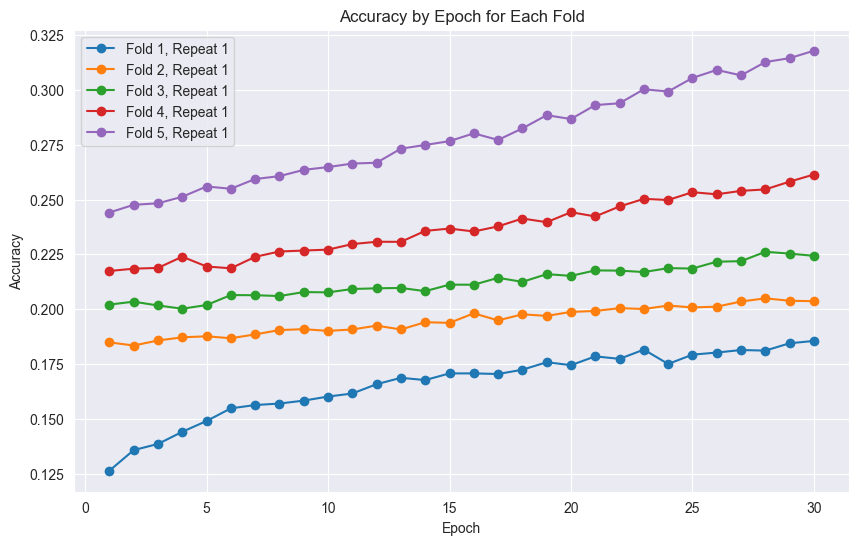

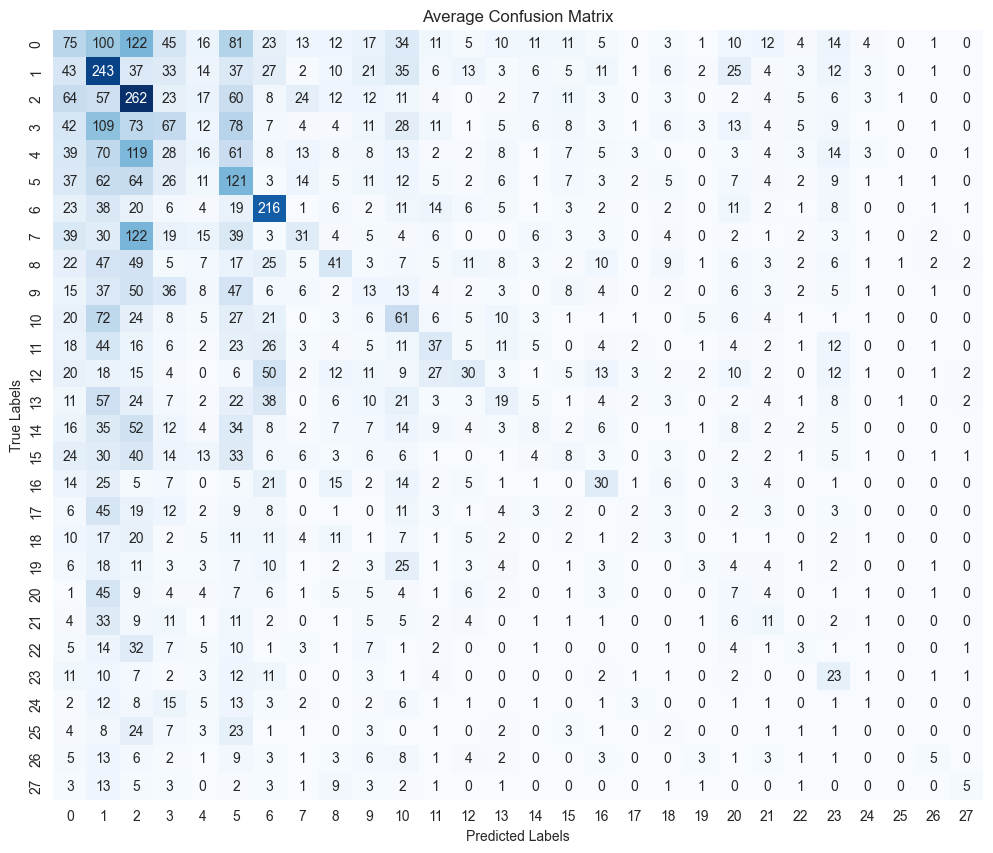

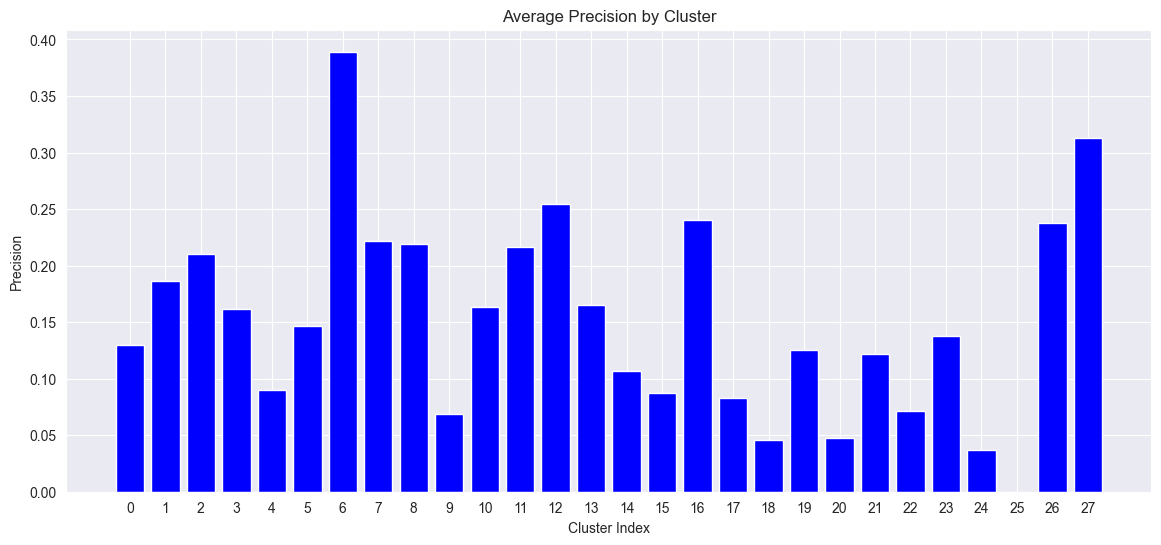

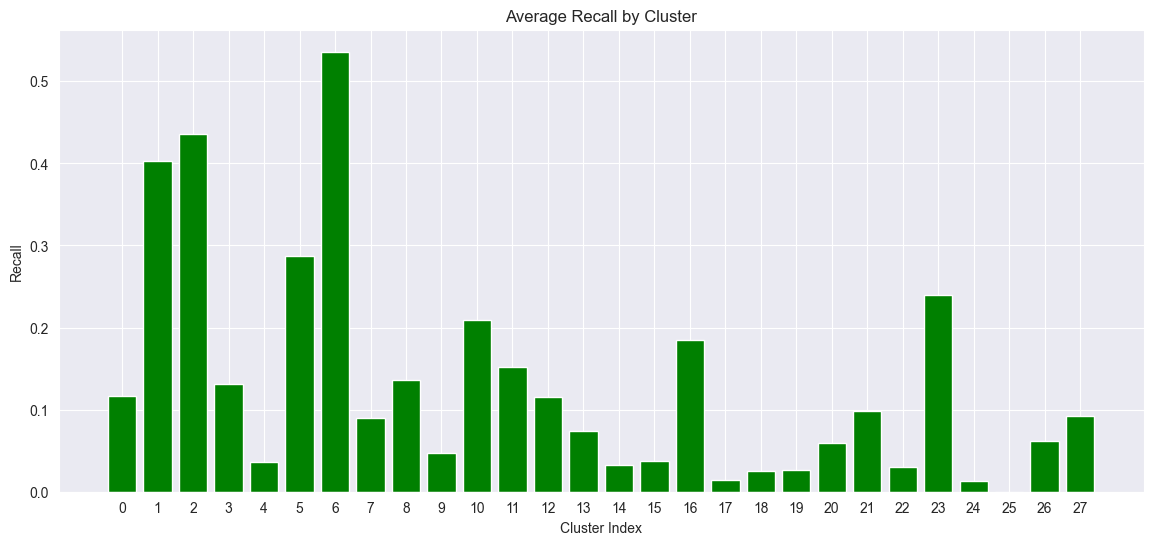

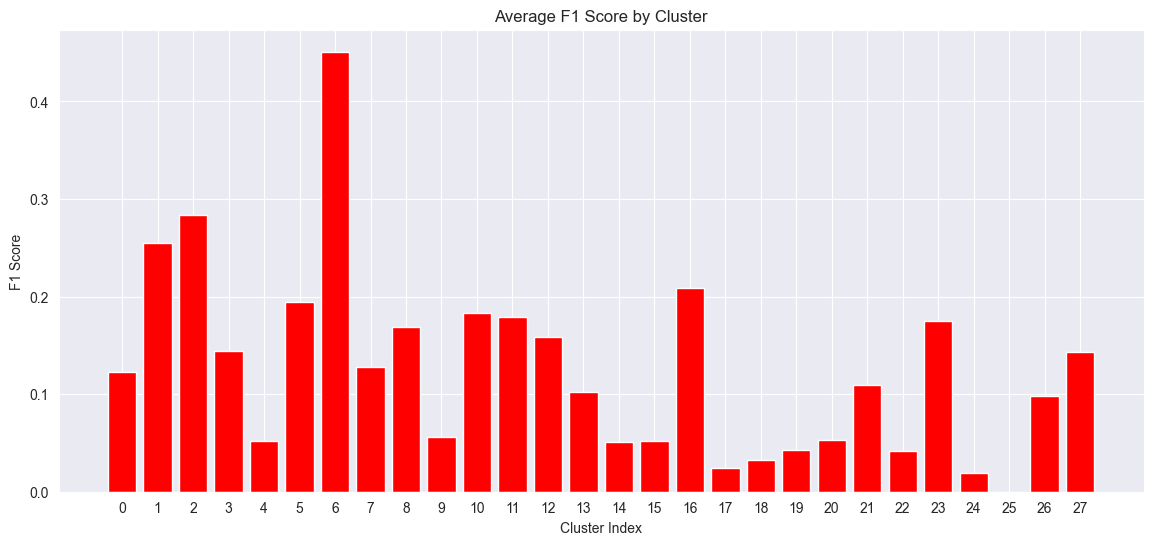

<Figure size 1400x800 with 0 Axes>

In [160]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_and_visualize_average_metrics(folder_path, num_folds=5,num_repeats=3):
    # Initialize lists to store fold data
    precision_lists = []
    recall_lists = []
    f1_score_lists = []
    conf_matrix_list = []
    all_epoch_accuracies = []

    for fold in range(1, num_folds + 1):
        for repeat in range(1,num_repeats+1):
            json_filepath = os.path.join(folder_path, f"evaluation_repeat_{repeat}_fold_{fold}.json")
            print(f"Loading data from {json_filepath}")
    
            with open(json_filepath, 'r') as file:
                data = json.load(file)
                fold_accuracies = []
                epoch_accuracies = data['epoch_accuracies']
                fold_accuracies.append(epoch_accuracies)
    
            all_epoch_accuracies.append(fold_accuracies)
        plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    for fold, fold_accuracies in enumerate(all_epoch_accuracies, start=1):
        for repeat, epoch_accuracies in enumerate(fold_accuracies, start=1):
            plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, marker='o', label=f'Fold {fold}, Repeat {repeat}')
    
    plt.title('Accuracy by Epoch for Each Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()   
    # Append the data for later processing
    conf_matrix_list.append(np.array(data['confusion_matrix']))
    precision_lists.append(data['Precision by cluster'])
    recall_lists.append(data['Recall by cluster'])
    f1_score_lists.append(data['F1 score by cluster'])

    # Calculate average of metrics across all folds
    avg_conf_matrix = np.mean(conf_matrix_list, axis=0)
    avg_precision = np.mean(precision_lists, axis=0)
    avg_recall = np.mean(recall_lists, axis=0)
    avg_f1_score = np.mean(f1_score_lists, axis=0)

    # Visualization of averaged results
    # Plotting the average confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(avg_conf_matrix, annot=True, fmt=".0f", cmap='Blues', cbar=False)
    plt.title('Average Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plotting Average Precision by Cluster
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(avg_precision)), avg_precision, color='blue')
    plt.title('Average Precision by Cluster')
    plt.xlabel('Cluster Index')
    plt.ylabel('Precision')
    plt.xticks(range(len(avg_precision)))  # Ensure all clusters are labeled
    plt.show()

    # Plotting Average Recall by Cluster
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(avg_recall)), avg_recall, color='green')
    plt.title('Average Recall by Cluster')
    plt.xlabel('Cluster Index')
    plt.ylabel('Recall')
    plt.xticks(range(len(avg_recall)))  # Ensure all clusters are labeled
    plt.show()

    # Plotting Average F1 Score by Cluster
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(avg_f1_score)), avg_f1_score, color='red')
    plt.title('Average F1 Score by Cluster')
    plt.xlabel('Cluster Index')
    plt.ylabel('F1 Score')
    plt.xticks(range(len(avg_f1_score)))  # Ensure all clusters are labeled
    plt.show()
    
    plt.figure(figsize=(14, 8))

            

    
# Example of calling the function with a path to the directory containing JSON files
load_and_visualize_average_metrics(save_path, num_folds=num_splits,num_repeats=num_repeats)
